# Código del Modelo de Regresión

## IMPORTAR LAS LIBRERIAS

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Transformación de datos

from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

#Crear Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Crear modelo

from sklearn.ensemble import RandomForestRegressor

#Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import cloudpickle

## CARGAR LOS DATOS

In [135]:
df = pd.read_excel('../../02_Datos/02_Validacion/validacion.xlsx')
df.head()

,Unnamed: 0,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,94,2012.916667,40.9,167.59890,5,24.96630,121.54026,41.0
1,204,2013.000000,18.0,1414.83700,1,24.95182,121.54887,26.6
2,360,2012.666667,32.9,87.30222,10,24.98300,121.54022,47.1
3,349,2012.750000,7.8,104.81010,5,24.96674,121.54067,47.0
4,109,2013.583333,4.0,2147.37600,3,24.96299,121.51284,28.4


## ESTRUCTURA DE LOS DATASETS

### CALIDAD DE DATOS

In [136]:
#renombramos las variables
df.rename(columns= {'X1 transaction date':'date',
       'X2 house age':'age',
       'X3 distance to the nearest MRT station':'distance_station',
       'X4 number of convenience stores':'stores',
       'X5 latitude':'latitude',
       'X6 longitude':'longitude',
       'Y house price of unit area':'price'},inplace=True)

#Eliminamos la columnas Unnamed: 0
df.drop(columns='Unnamed: 0', inplace=True)

#Creamos las variables mes y año
# Separar los datos en tres columnas
df[['year', 'mes']] = df['date'].apply(lambda x: pd.Series(str(x).split('.')))
df['year'] = df.year.astype('object')
df['mes'] = df['mes'].apply(lambda x: str(x)[0] + '.' + str(x)[1:])
df['mes'] = df.mes.astype('float64')
df['mes'] = df.mes.apply(lambda x: int((x / 0.833) +1))
df['mes'] = df.mes.astype('object')

#Eliminamos columna date
df.drop(columns='date',inplace= True)

#Eliminamos duplicados
df.drop_duplicates(inplace= True)

#Eliminamos nulos

df.dropna(thresh= 1, inplace=True)

#### Separar target

In [137]:
variables_finales = ['distance_station','latitude','stores','age','year','price'] 

In [138]:
df = df[variables_finales]

In [139]:
y = df.price.copy()
x= df.drop(columns= 'price').copy()

### TRANSFORMACIÓN DE VARIABLES

Realizamos el logaritmo de la target

In [140]:
y = np.log(y)

#### Target Encoder

In [141]:
var_te =  ['year']
te  = TargetEncoder(min_samples_leaf= 100, return_df= False)
cat_te = te.fit_transform(x[var_te], y= y)
nombre_var_te = [variable + '_te' for variable in var_te] 
cat_te = pd.DataFrame(cat_te, columns= nombre_var_te)
x = pd.concat([cat_te, x], axis= 1)
x.drop(columns=var_te,inplace=True)


#### Min_Max Scaler

In [142]:
# MimMaxScaler al Dataset
var_mms = ['year_te', 'distance_station', 'stores', 'latitude','age']
mms = MinMaxScaler()
df_mms = mms.fit_transform(x[var_mms])
nombre_mms = [variable + '_mms' for variable in var_mms]
x = pd.DataFrame(df_mms, columns= nombre_mms)

In [143]:
x

,year_te_mms,distance_station_mms,stores_mms,latitude_mms,age_mms
0,0.0,0.022308,0.5,0.567228,0.933790
1,1.0,0.215241,0.1,0.321095,0.410959
2,0.0,0.009888,1.0,0.851096,0.751142
3,0.0,0.012596,0.5,0.574707,0.178082
4,1.0,0.328556,0.3,0.510964,0.091324
...,...,...,...,...,...
119,0.0,0.285221,0.2,0.869284,0.116438
120,0.0,0.025384,0.1,0.696073,0.289954
121,0.0,0.021433,0.9,0.860105,0.705479
122,1.0,0.272219,0.3,0.584396,0.406393


In [144]:
x = x[['distance_station_mms','latitude_mms', 'stores_mms' ,  'age_mms', 'year_te_mms']]

## MODELIZAR CON EL PIPE DE EJECUCCIÓN

In [145]:
ruta_pipe_ejecucion = '../../04_Modelos/pipe_ejecucion.pickle'
with open(ruta_pipe_ejecucion, mode= 'rb') as file:
    pipe_ejecucion = cloudpickle.load(file)

In [146]:
pred = pipe_ejecucion.predict(x)

In [147]:
pred = np.exp(pred)
y = np.exp(y)

## EVALUAR CON DATASET DE VALIDACIÓN

In [148]:
print("%mape:", mean_absolute_percentage_error(y, pred))
print("Coeficiente de determinación:", r2_score(y,pred))
print("MAE:", mean_absolute_error(y, pred))
print("RMSE:", mean_squared_error(y,pred,squared='False'))


%mape: 0.18925625860634027
Coeficiente de determinación: 0.6668061598252162
MAE: 5.28818122208976
RMSE: 51.27863515083623


#### Gráfico entre la diferencia entre la validación y el original

In [149]:
test_y = y.reset_index().copy()
test_pred = pd.Series(pred).to_frame()
df_pred = pd.concat([test_y,test_pred], axis= 1).sort_values(by='price').reset_index()
df_pred.rename(columns = {0:'pred'}, inplace = True)
df_pred = df_pred.drop(columns= ['level_0'])
df_pred['dif'] = abs(df_pred['price']-df_pred['pred'])
# Diferencia entre predicción y validación
df_pred.sort_values(by = 'dif', ascending = False)

,index,price,pred,dif
0,30,7.6,41.563669,33.963669
120,56,61.5,38.409107,23.090893
85,43,45.1,24.387781,20.712219
123,86,63.3,48.610049,14.689951
15,50,23.0,35.849475,12.849475
...,...,...,...,...
106,27,51.8,51.498923,0.301077
21,89,25.6,25.811359,0.211359
23,28,25.9,26.068272,0.168272
75,76,42.3,42.457420,0.157420


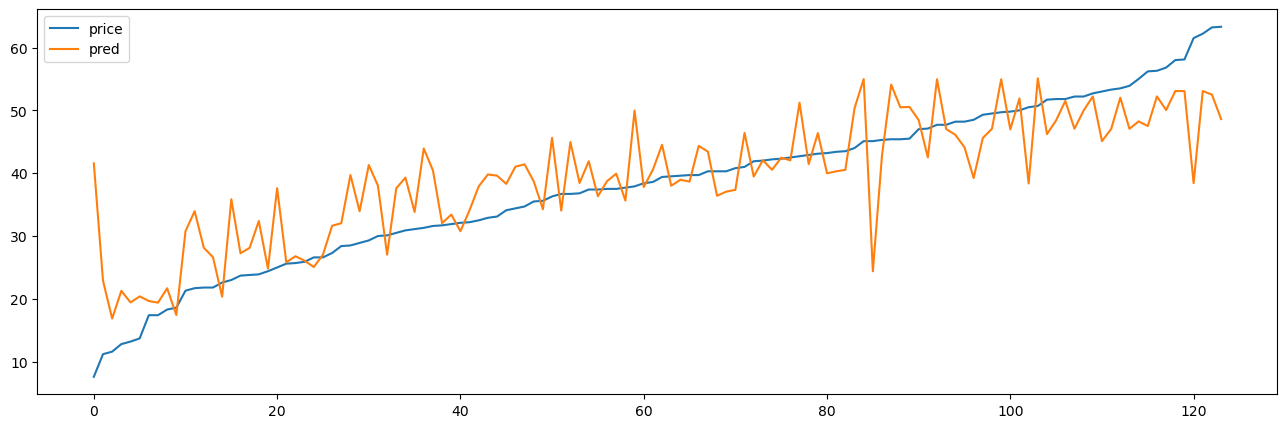

In [150]:
df_pred[['price','pred']].plot(figsize=(16,5));

## Gráficios de validación modelos de regresión

2. Gráfico de residuos vs. valores predichos: 


Un gráfico de residuos muestra los residuos (diferencias entre los valores observados y los valores predichos por el modelo) en función de los valores ajustados o las variables independientes. Este gráfico puede ayudarte a verificar si los residuos tienen algún patrón sistemático, como una relación no lineal o una heterocedasticidad.

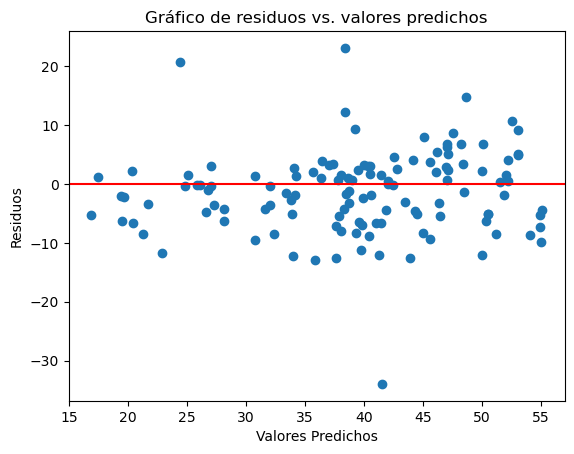

In [151]:
val_y = y
residuos = val_y - pred

plt.scatter(pred, residuos)
plt.axhline(y=0, color='red')  # Línea horizontal en cero
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs. valores predichos')
plt.show()


3. Histograma de residuos:

 Este gráfico muestra la distribución de los residuos del modelo. Puedes utilizar un histograma o un gráfico de densidad para visualizar cómo se distribuyen los residuos y verificar si siguen una distribución aproximadamente normal.

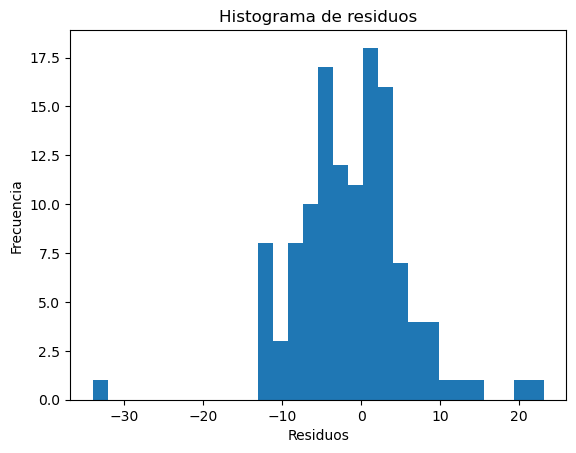

In [152]:
plt.hist(residuos, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de residuos')
plt.show()

4. Gráfico de Q-Q (cuantil-cuantil):

Este gráfico compara los cuantiles de los residuos con los cuantiles esperados de una distribución normal. Puede ayudarte a evaluar si los residuos siguen una distribución normal.

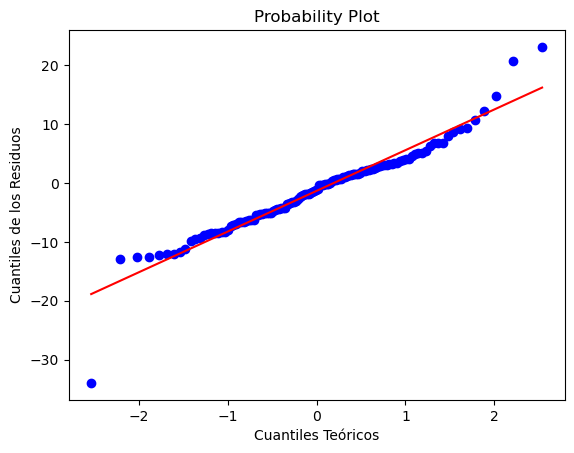

In [153]:
import scipy.stats as stats

stats.probplot(residuos, dist="norm", plot=plt)
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de los Residuos')
plt.show()


5. Gráfico de influencia:

Un gráfico de influencia muestra la influencia de cada observación en el ajuste del modelo. Puede ayudarte a identificar puntos atípicos o valores influyentes que pueden tener un impacto significativo en los resultados de la regresión.

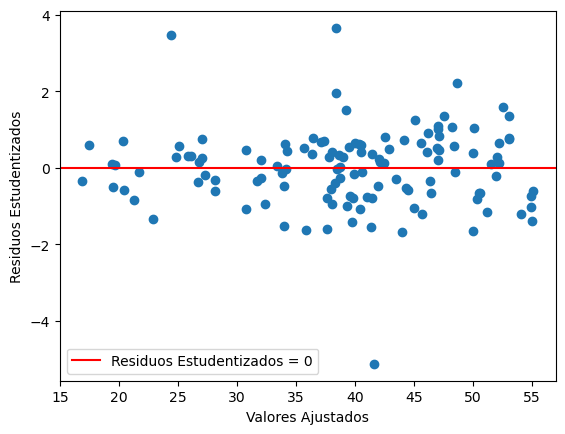

In [154]:
import statsmodels.api as sm

infl = sm.OLS(val_y, sm.add_constant(pred)).fit().get_influence()
residuos_estudentizados = infl.resid_studentized_external

plt.scatter(pred, residuos_estudentizados)
plt.axhline(y=0, color='r', linestyle='-', label='Residuos Estudentizados = 0')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos Estudentizados')
plt.legend()
plt.show()